In [1]:
import os
import numpy as np
import pandas as pd
from utilities import cal_score

In [2]:
stack_idx = '20'
models = '33,35-37'
use_test_kfold = set([2, 7, 8, 12, 13])

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[33, 35, 36, 37]


In [45]:
# File candidate
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
{idx: [f for f in files_in_output 
       if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')]
 for idx in idx_models}

{33: ['model-33-lgb-remove_outlier_03-test-one.csv'],
 35: ['model-35-lgb-remove_outlier_03-2-test-one.csv'],
 36: ['model-36-lgb-remove_outlier_03-0.001-2-test-one.csv'],
 37: ['model-37-lgb-remove_outlier_05-test-one.csv']}

In [8]:
# files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
# # files_cv = {idx: [f for f in files_in_output 
# #                   if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
# #             for idx in idx_models}
# files_test_one = {idx: [f for f in files_in_output 
#                         if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
#                   for idx in idx_models}
# files_test_kf = {idx: [f for f in files_in_output 
#                        if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
#                  for idx in idx_models}
files_test_one = {
    33: 'model-33-lgb-remove_outlier_03-test-one.csv',
    35: 'model-35-lgb-remove_outlier_03-2-test-one-400000.csv',
    36: 'model-36-lgb-remove_outlier_03-0.001-2-test-one.csv',
    37: 'model-37-lgb-remove_outlier_05-test-one.csv',
}

In [24]:
dfs = [pd.read_csv('output/'+f).rename({'total_price': 'pred_'+str(i)}, axis=1) 
       for i, f in files_test_one.items()]
df = dfs[0]
for df_i in dfs[1:]:
    df = df.merge(df_i, on='building_id', how='inner')

cols_pred = ['pred_'+str(i) for i in files_test_one]
print(cols_pred)

In [25]:
df.check()

,building_id,pred_33,pred_35,pred_36,pred_37
0,X5gsdTWGS3W7JJQB,1.334910e+07,1.313244e+07,1.298618e+07,1.304845e+07
1,BTshNOJyKHnT2YIT,3.890587e+06,3.896216e+06,3.897411e+06,3.897545e+06
2,dhdymr0lV8N5kZOT,1.059390e+07,1.078764e+07,1.049745e+07,1.035078e+07
3,VEwyGGMcD56w5BOc,6.119229e+06,6.102227e+06,6.139949e+06,6.120593e+06
4,wmUeMoJZfsqaSX9b,1.110317e+06,1.104233e+06,1.106728e+06,1.098338e+06
9995,UEeCDaAJzPwdKKKA,1.181563e+06,1.191904e+06,1.191593e+06,1.175668e+06
9996,i0fgbPaQsDWs7Q87,4.817584e+07,4.858715e+07,4.826300e+07,4.830921e+07
9997,YunNwAhcqkf6YclI,1.094032e+06,1.108525e+06,1.114377e+06,1.142751e+06
9998,A2NotxtRY9MYoWMl,2.970882e+06,2.962741e+06,2.973267e+06,2.933060e+06
9999,kKvgBXiA50gRmQhP,3.129095e+06,3.118331e+06,3.102721e+06,3.067082e+06


shape = (10000, 5)


In [30]:
assert not (df == 0).any().any()

# to log
for c in cols_pred:
    df['log_'+c] = np.log(df[c])
cols_log_pred = ['log_'+c for c in cols_pred]
cols_log_pred

df['log_total_price'] = df.loc[:, cols_log_pred].mean(axis=1)
df['total_price'] = np.exp(df['log_total_price'])

In [37]:
df.check()

,building_id,pred_33,pred_35,pred_36,pred_37,log_pred_33,log_pred_35,log_pred_36,log_pred_37,log_total_price,total_price
0,X5gsdTWGS3W7JJQB,1.334910e+07,1.313244e+07,1.298618e+07,1.304845e+07,16.406960,16.390596,16.379396,16.384180,16.390283,1.312833e+07
1,BTshNOJyKHnT2YIT,3.890587e+06,3.896216e+06,3.897411e+06,3.897545e+06,15.174070,15.175516,15.175823,15.175857,15.175317,3.895439e+06
2,dhdymr0lV8N5kZOT,1.059390e+07,1.078764e+07,1.049745e+07,1.035078e+07,16.175789,16.193911,16.166643,16.152573,16.172229,1.055625e+07
3,VEwyGGMcD56w5BOc,6.119229e+06,6.102227e+06,6.139949e+06,6.120593e+06,15.626947,15.624164,15.630327,15.627169,15.627152,6.120485e+06
4,wmUeMoJZfsqaSX9b,1.110317e+06,1.104233e+06,1.106728e+06,1.098338e+06,13.920156,13.914661,13.916918,13.909309,13.915261,1.104895e+06
9995,UEeCDaAJzPwdKKKA,1.181563e+06,1.191904e+06,1.191593e+06,1.175668e+06,13.982349,13.991063,13.990802,13.977347,13.985390,1.185162e+06
9996,i0fgbPaQsDWs7Q87,4.817584e+07,4.858715e+07,4.826300e+07,4.830921e+07,17.690368,17.698870,17.692176,17.693133,17.693637,4.833355e+07
9997,YunNwAhcqkf6YclI,1.094032e+06,1.108525e+06,1.114377e+06,1.142751e+06,13.905380,13.918541,13.923806,13.948949,13.924169,1.114782e+06
9998,A2NotxtRY9MYoWMl,2.970882e+06,2.962741e+06,2.973267e+06,2.933060e+06,14.904369,14.901625,14.905172,14.891557,14.900681,2.959944e+06
9999,kKvgBXiA50gRmQhP,3.129095e+06,3.118331e+06,3.102721e+06,3.067082e+06,14.956254,14.952809,14.947790,14.936237,14.948272,3.104218e+06


shape = (10000, 11)


In [63]:
df[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.312833e+07
1,BTshNOJyKHnT2YIT,3.895439e+06
2,dhdymr0lV8N5kZOT,1.055625e+07
3,VEwyGGMcD56w5BOc,6.120485e+06
4,wmUeMoJZfsqaSX9b,1.104895e+06
9995,UEeCDaAJzPwdKKKA,1.185162e+06
9996,i0fgbPaQsDWs7Q87,4.833355e+07
9997,YunNwAhcqkf6YclI,1.114782e+06
9998,A2NotxtRY9MYoWMl,2.959944e+06
9999,kKvgBXiA50gRmQhP,3.104218e+06


shape = (10000, 2)


In [41]:
# Output
output_filename = 'output/stack_meanlog_no_search_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_meanlog_no_search_20_33,35-37.csv


In [42]:
df[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [65]:
# Check null
df.isnull().any()

building_id        False
pred_33            False
pred_35            False
pred_36            False
pred_37            False
log_pred_33        False
log_pred_35        False
log_pred_36        False
log_pred_37        False
log_total_price    False
total_price        False
dtype: bool

### Compare distribution

In [43]:
import matplotlib.pyplot as plt

In [57]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [67]:
df_train['total_price'].describe()

count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

In [68]:
df_test['total_price'].describe()

count    1.000000e+04
mean     1.289628e+07
std      5.464583e+07
min      2.052908e+05
25%      2.443947e+06
50%      5.151208e+06
75%      1.082656e+07
max      3.024236e+09
Name: total_price, dtype: float64

In [58]:
df_test = df_test.merge(df, on='building_id', how='inner')

In [59]:
df_train['log_total_price'] = np.log(df_train['total_price'])
df_train['parea_total_price'] = df_train['total_price'] / df_train['building_area']
df_train['log_parea_total_price'] = np.log(df_train['parea_total_price'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


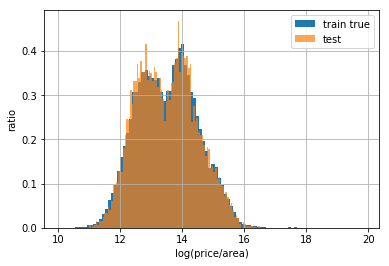

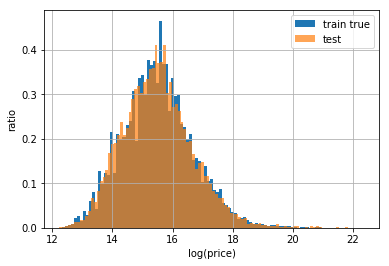

In [62]:
plt.hist(df_train['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_test['total_price'] / df_test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(df_train['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log(df_test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()